In [1]:
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import preprocessing
import cv2
import glob
import os
import warnings as wr
from IPython import display


wr.filterwarnings("ignore")

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
train_path = r'D:/pedes/Train/Train/JPEGImages'
train_annot = r'D:/pedes/Train/Train/Annotations'

test_path = r'D:/pedes/Test/Test/JPEGImages'
test_annot = r'D:/pedes/Test/Test/Annotations'

val_path = r'D:/pedes/Val/Val/JPEGImages'
val_annot = r'D:/pedes/Val/Val/Annotations'

# XML to DataFrame

In [4]:
def creatingInfoData(Annotpath):
    information={'xmin':[],'ymin':[],'xmax':[],'ymax':[],'ymax':[],'name':[]
                ,'label':[]}

    for file in sorted(glob.glob(str(Annotpath+'/*.xml*'))):
        dat=ET.parse(file)
        for element in dat.iter():    

            if 'object'==element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text                 
                        information['label'] += [name]
                        information['name'] +=[file.split('/')[-1][12:-4]]

                    if 'bndbox'==attribute.tag:
                        for dim in list(attribute):
                            if 'xmin'==dim.tag:
                                xmin=int(round(float(dim.text)))
                                information['xmin']+=[xmin]
                            if 'ymin'==dim.tag:
                                ymin=int(round(float(dim.text)))
                                information['ymin']+=[ymin]
                            if 'xmax'==dim.tag:
                                xmax=int(round(float(dim.text)))
                                information['xmax']+=[xmax]
                            if 'ymax'==dim.tag:
                                ymax=int(round(float(dim.text)))
                                information['ymax']+=[ymax]
                     
    return pd.DataFrame(information)

In [5]:
train_info = creatingInfoData(train_annot)
test_info = creatingInfoData(test_annot)
val_info = creatingInfoData(val_annot)

In [6]:
train_info.head(2)

xmin  ymin  xmax  ymax        name   label
0   158    44   289   167   image (1)  person
1   185    56   287   241  image (10)  person

In [7]:
test_info.head(2)

xmin  ymin  xmax  ymax        name   label
0     8    12   352   498   image (1)  person
1    22    70   254   327  image (10)  person

In [8]:
val_info.head(2)

xmin  ymin  xmax  ymax       name   label
0     1   107   322   350  image (1)  person
1     1    65   218   343  image (1)  person

## Visualizing the dataset

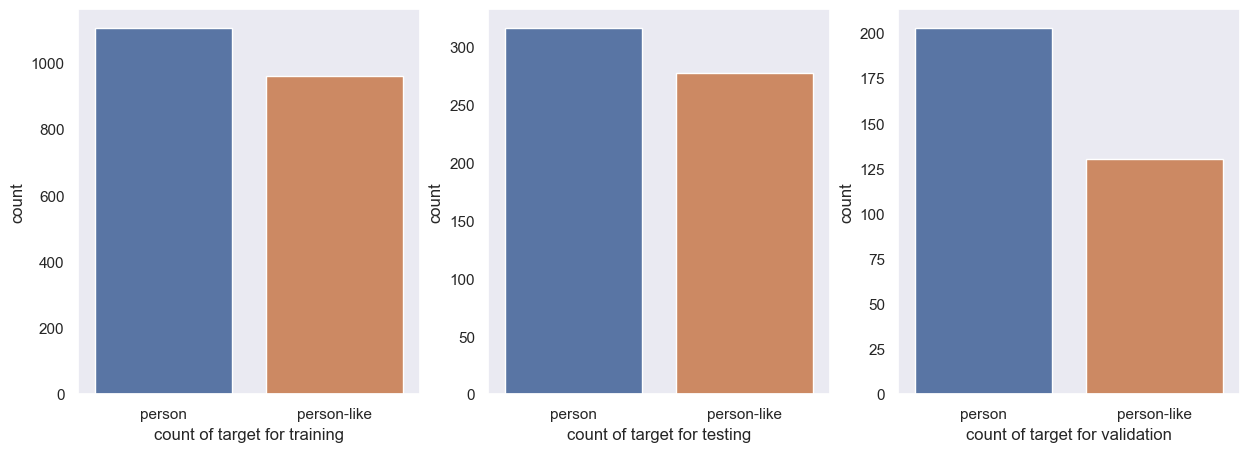

In [9]:
fig=plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.countplot(x=train_info['label'])
plt.xlabel('count of target for training')

plt.subplot(1,3,2)
sns.countplot(x=test_info['label'])
plt.xlabel('count of target for testing')


plt.subplot(1,3,3)
sns.countplot(x=val_info['label'])
plt.xlabel('count of target for validation')

plt.show()

# Loading a sample image

In [10]:
train_info.loc[train_info['name']=='image (7)']

xmin  ymin  xmax  ymax       name   label
1462   431   106   474   253  image (7)  person
1463    39   111    81   262  image (7)  person

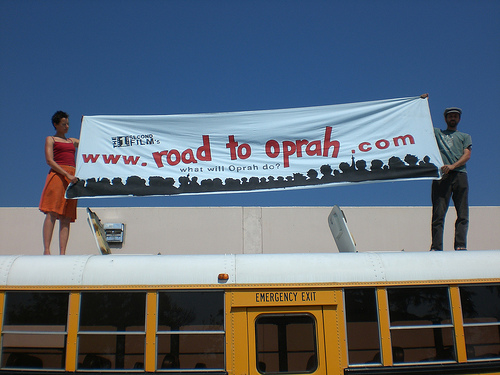

In [11]:
display.Image(train_path+'/image (7).jpg')

# Marking the boundaries for sample image

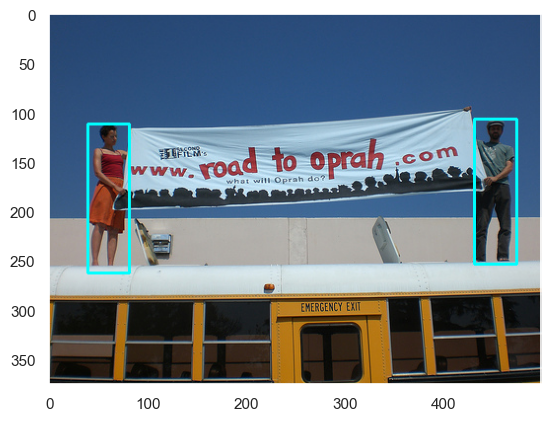

In [12]:
img = cv2.imread(train_path+'/image (7).jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

# xmin, ymin  xmax, ymax
cv2.rectangle(img,(431,106), (474, 253), (0, 255, 255), 2)
cv2.rectangle(img,(39,111),(81,262),(0,255,255), 2)

plt.imshow(img);

In [13]:
train_info.loc[train_info['name']=='image (7)']

xmin  ymin  xmax  ymax       name   label
1462   431   106   474   253  image (7)  person
1463    39   111    81   262  image (7)  person

# Extracting the boundary box

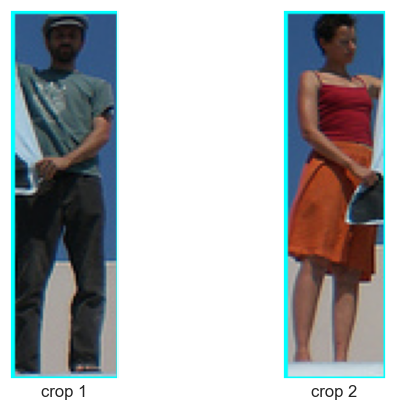

In [14]:
#  y-min, y-max , x-min , x-max
fig=plt.figure()

plt.subplot(1,2,1)
plt.imshow(img[106:253,431:474])
plt.xticks([])
plt.yticks([])
plt.xlabel('crop 1')

plt.subplot(1,2,2)
plt.imshow(img[111:262,39:81])
plt.xticks([])
plt.yticks([])
plt.xlabel('crop 2')

plt.show()

# Generalizing the task via a function

In [15]:
def croppingFromImage(path,Data_information):
    cropped_image=[]
    label=[]
    for i in range(0,len(Data_information)):
        img=cv2.imread(path+'/'+Data_information['name'][i]+'.jpg',cv2.IMREAD_COLOR)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_=img[Data_information['ymin'][i]:Data_information['ymax'][i],Data_information['xmin'][i]:Data_information['xmax'][i]]
        cropped_image.append(img_)
        
        label.append(Data_information['label'][i])
    return cropped_image , label   

In [16]:
trainImage , trainLabel = croppingFromImage(train_path,train_info)
testImage , testLabel = croppingFromImage(test_path,test_info)
valImage , valLabel = croppingFromImage(val_path,val_info)

In [17]:
print(len(trainImage) == len(trainLabel))
print(len(testImage) == len(testLabel))
print(len(valImage) == len(valLabel))

True
True
True


# Visualizing the cropped images

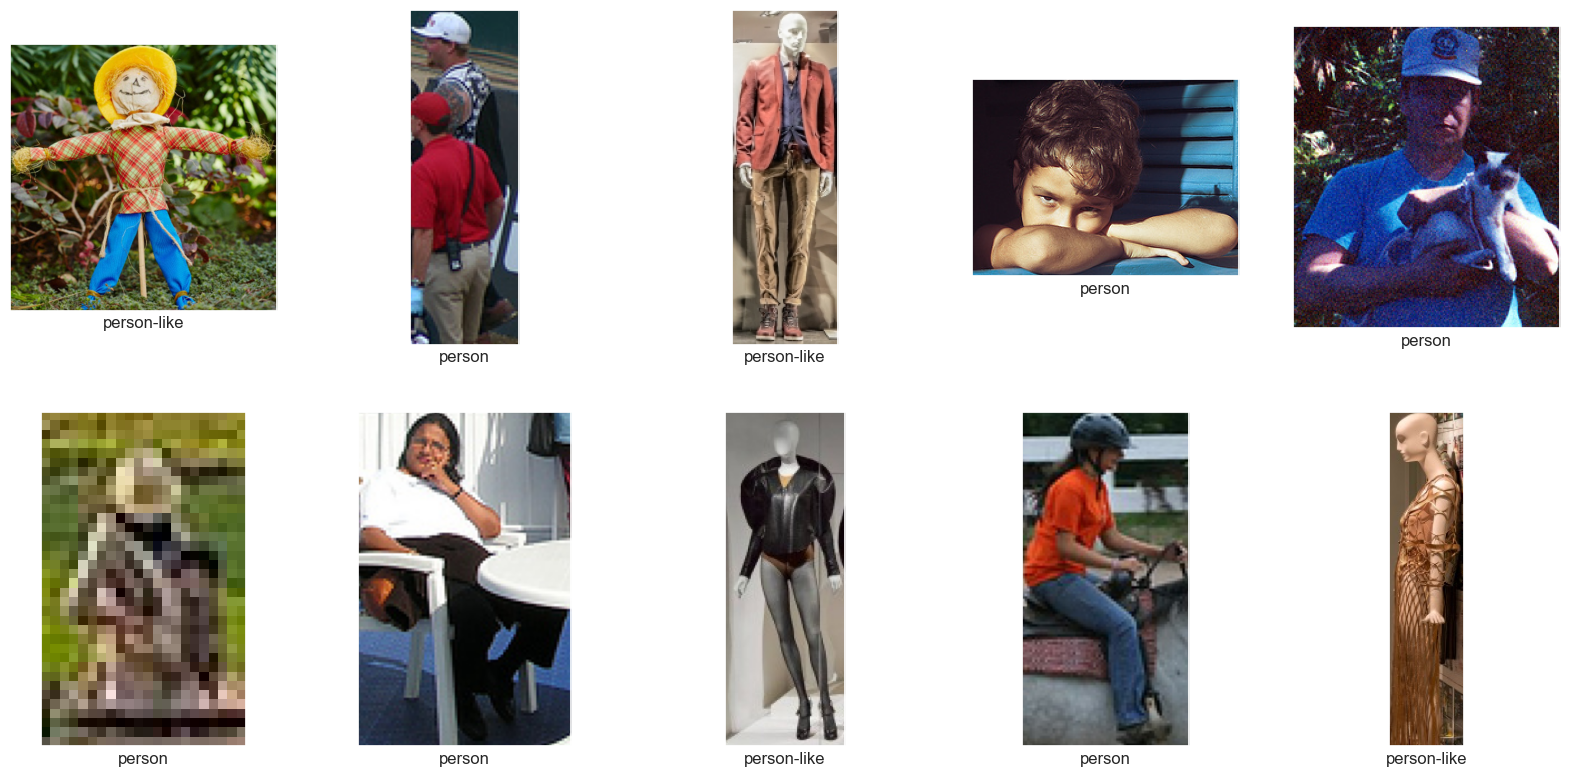

In [18]:
fig=plt.figure(figsize=(20,20))

for i in range (1,11):
    random=np.random.randint(0,len(trainImage))
    plt.subplot(4,5,i)
    plt.imshow(trainImage[random])
    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

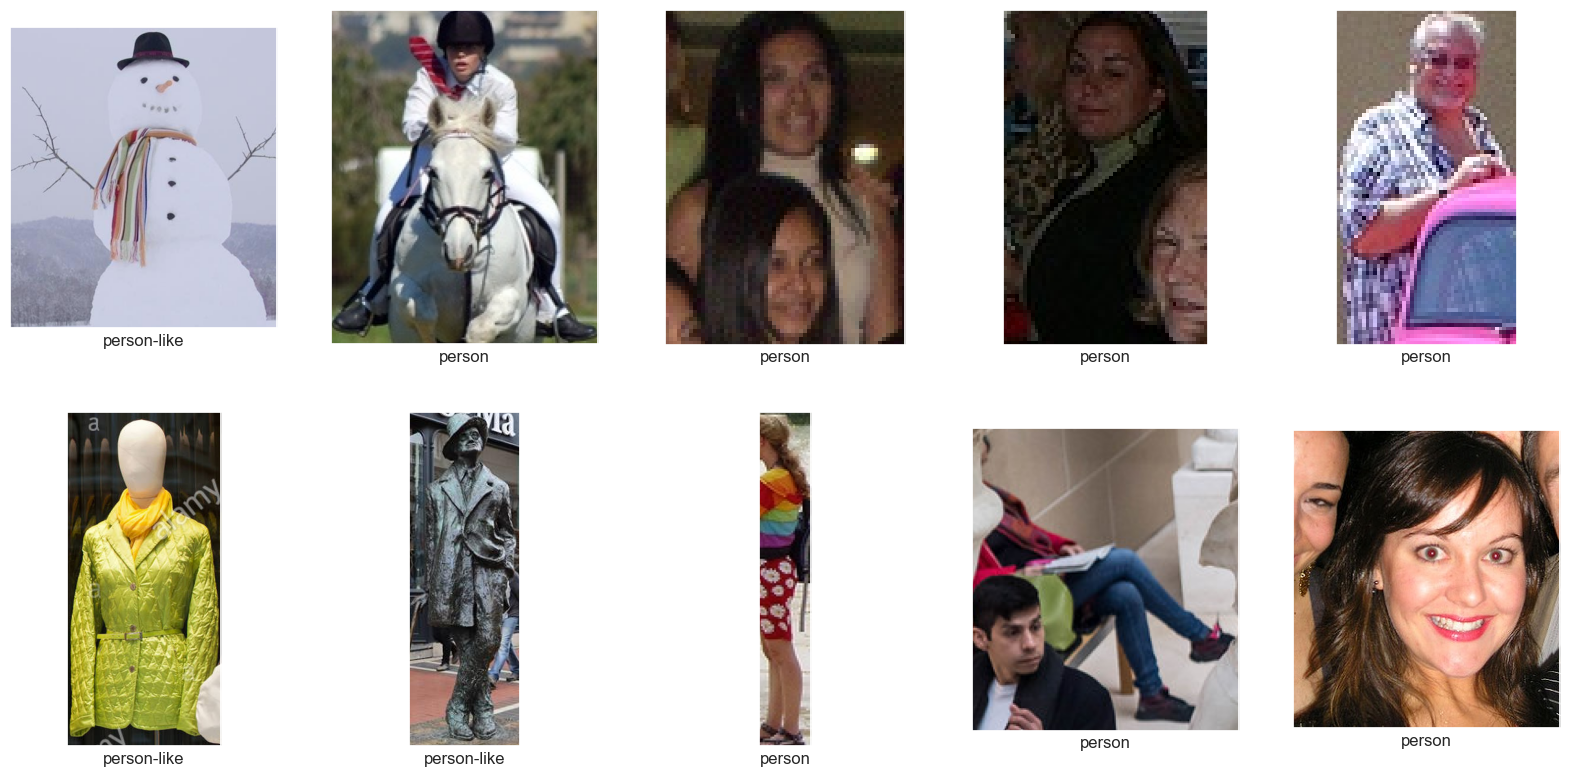

In [19]:
fig=plt.figure(figsize=(20,20))

for i in range (1,11):
    random=np.random.randint(0,len(testImage))
    plt.subplot(4,5,i)
    plt.imshow(testImage[random])
    plt.xlabel(testLabel[random])
    plt.xticks([])
    plt.yticks([])

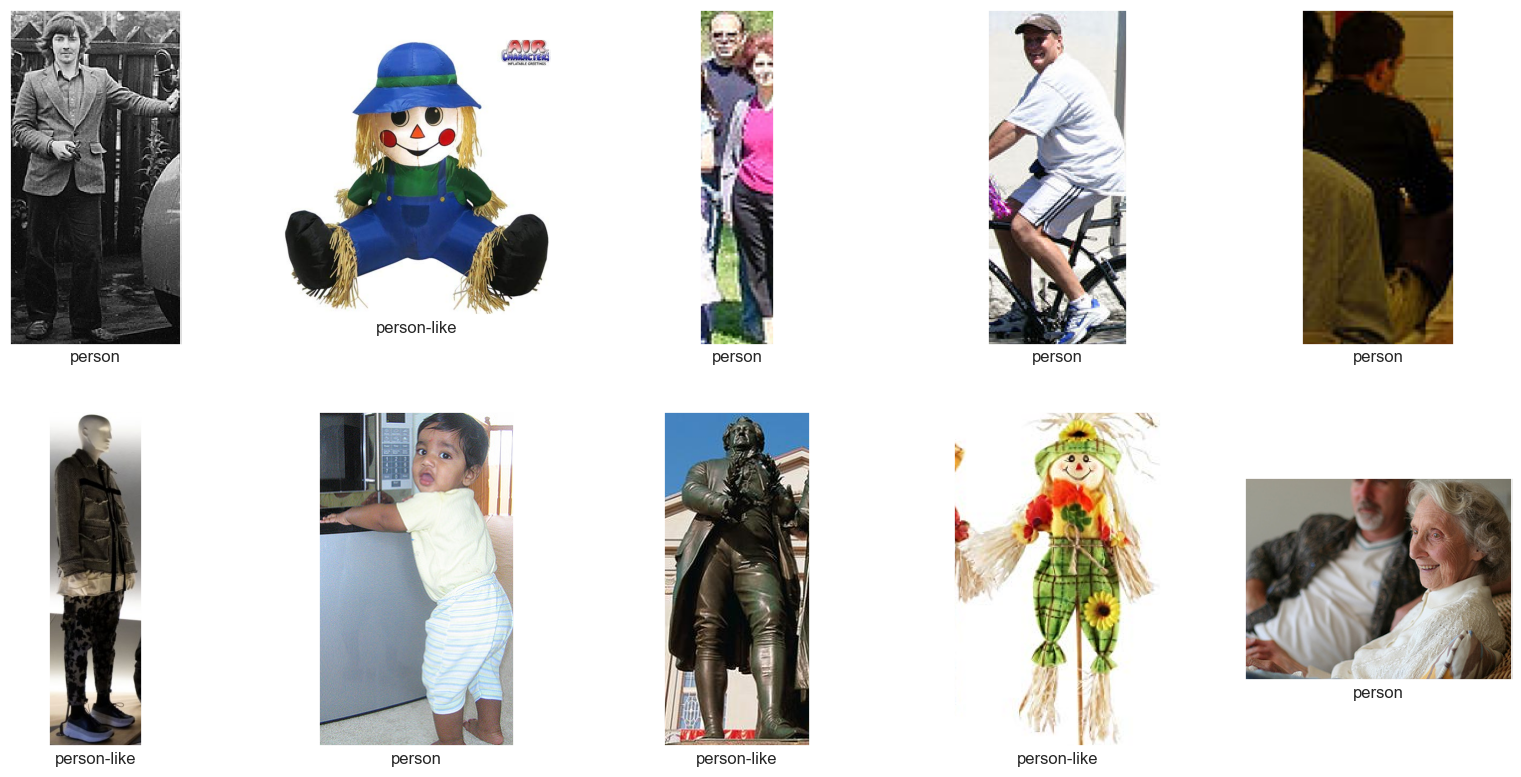

In [20]:
fig=plt.figure(figsize=(20,20))

for i in range (1,11):
    random=np.random.randint(0,len(valImage))
    plt.subplot(4,5,i)
    plt.imshow(valImage[random])
    plt.xlabel(valLabel[random])
    plt.xticks([])
    plt.yticks([])

# Reshaping the images

In [21]:
trainShapes=[]
testShapes=[]
valShapes=[]
for i in trainImage :
    trainShapes.append(i.shape)
    
for i in testImage :
    testShapes.append(i.shape)
    
for i in valImage:
    valShapes.append(i.shape)

In [22]:
pd.Series(trainShapes).value_counts()[:10]

(374, 499, 3)    4
(162, 58, 3)     2
(280, 252, 3)    2
(151, 60, 3)     2
(358, 271, 3)    2
(95, 43, 3)      2
(44, 34, 3)      2
(101, 49, 3)     2
(101, 32, 3)     2
(284, 92, 3)     2
dtype: int64

In [23]:
pd.Series(testShapes).value_counts()[:10]

(85, 52, 3)      2
(128, 58, 3)     2
(128, 47, 3)     2
(120, 37, 3)     2
(171, 74, 3)     2
(105, 81, 3)     2
(506, 449, 3)    1
(225, 128, 3)    1
(180, 94, 3)     1
(187, 85, 3)     1
dtype: int64

In [24]:
pd.Series(valShapes).value_counts()[:10]

(131, 51, 3)     2
(492, 207, 3)    2
(243, 321, 3)    1
(256, 83, 3)     1
(413, 206, 3)    1
(134, 46, 3)     1
(129, 40, 3)     1
(142, 37, 3)     1
(271, 219, 3)    1
(202, 95, 3)     1
dtype: int64

In [25]:
def resizing(data,size):
    resizing=[]
    for i in data:
        resizing.append(cv2.resize(i,(size,size)))
        
    return resizing   

# Resizing the image to 224,224 to fit to the VGG16 feature extractor

In [26]:
s=224
X_train,X_test=resizing(trainImage,s),resizing(testImage,s)

# Changing the labels to fetaure vectors via label encoding

In [27]:
labeling=preprocessing.LabelEncoder()
y_train=labeling.fit_transform(trainLabel)
y_test=labeling.fit_transform(testLabel)

In [28]:
X_val = resizing(valImage, s)

In [29]:
y_label=labeling.fit_transform(valLabel)

In [30]:
X_train,X_test,X_val=np.asarray(X_train).astype(np.float32),np.asarray(X_test).astype(np.float32),np.asarray(X_val).astype(np.float32)
X_train,X_test,X_val=X_train/255.0,X_test/255.0,X_val/255.0

# Loading the VGG16 model for feature extraction

In [31]:
# !pip uninstall scikit-learn

In [32]:
# !pip install scikit-learn

In [33]:
from PIL import Image
from keras.applications.vgg16 import preprocess_input, VGG16
from sklearn.model_selection import train_test_split
import numpy as np

In [34]:
!python --version

Python 3.10.9


In [35]:
vgg16 = VGG16(weights='imagenet', include_top=False)

In [36]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Extracting the training features

In [37]:
x_train_feature = vgg16.predict(X_train)

65/65 [==============================] - 388s 6s/step


In [43]:
x_train_feature.shape

(2066, 7, 7, 512)

### Reshaping the extracted features

In [44]:
n_samples = x_train_feature.shape[0]
x_train_feature_flat = np.reshape(x_train_feature, (n_samples, -1))

In [45]:
x_train_feature_flat.shape

(2066, 25088)

In [46]:
y_train.shape

(2066,)

## Initializing a Random Forest Classifier Model

In [54]:
# from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, 
                             max_depth=7, 
                             min_samples_split=3, 
                             min_samples_leaf=2, 
                             max_features='sqrt',
                             criterion='gini',
                             random_state=42,
                             n_jobs=-1)

In [55]:
rf

RandomForestClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=3,
                       n_jobs=-1, random_state=42)

## Training the random forest classifier

In [56]:
rf.fit(x_train_feature_flat, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=3,
                       n_jobs=-1, random_state=42)

In [57]:
print(rf.score(x_train_feature_flat,y_train))

0.9854791868344628


## Feature extraction of validation split

In [58]:
x_val_feature=vgg16.predict(X_val)

11/11 [==============================] - 51s 5s/step


In [59]:
x_val_feature.shape

(333, 7, 7, 512)

In [60]:
y_label.shape

(333,)

### RFC expects 2D shape, therefore reshaping it

In [61]:
n_samples = x_val_feature.shape[0]
x_val_feature_flat = np.reshape(x_val_feature, (n_samples, -1))

In [62]:
x_val_feature_flat.shape

(333, 25088)

In [63]:
y_label.shape

(333,)

## Testing on validation data

In [64]:
rf.score(x_val_feature_flat, y_label)

0.8558558558558559

## Similar process on Test Data

In [65]:
x_test_feature = vgg16.predict(X_test)

19/19 [==============================] - 89s 5s/step


In [66]:
x_test_feature.shape

(595, 7, 7, 512)

In [67]:
y_test.shape

(595,)

In [68]:
n_samples = x_test_feature.shape[0]
x_test_feature_flat = np.reshape(x_test_feature, (n_samples, -1))

In [69]:
x_test_feature_flat.shape

(595, 25088)

In [70]:
rf.score(x_test_feature_flat, y_test)

0.7647058823529411

# Metrics evaluation

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [72]:
def calculate_metrices(y_true, y_preds):
    
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    
    report = classification_report(y_true, y_preds)

    
    df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [accuracy, precision, recall, f1]
    })

    return (report, df)

In [73]:
def plot_met(df):
    plt.bar(df['Metric'], df['Score'])
    plt.ylim([0, 1])
    plt.title('Classification Results')
    plt.ylabel('Score')
    plt.show()

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def cmh(y_true, y_preds):
    cm = confusion_matrix(y_true, y_preds)

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## For validation split

In [75]:
x_val_feature=vgg16.predict(X_val)
n_samples = x_val_feature.shape[0]
x_val_feature_flat = np.reshape(x_val_feature, (n_samples, -1))

11/11 [==============================] - 50s 4s/step


In [76]:
y_val_preds = rf.predict(x_val_feature_flat)

In [77]:
y_val_preds.shape

(333,)

In [78]:
y_label.shape

(333,)

In [79]:
report, val_df = calculate_metrices(y_label, y_val_preds)

In [80]:
print(report)

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       203
           1       0.82      0.81      0.81       130

    accuracy                           0.86       333
   macro avg       0.85      0.85      0.85       333
weighted avg       0.86      0.86      0.86       333



In [81]:
val_df

Metric     Score
0   Accuracy  0.855856
1  Precision  0.820312
2     Recall  0.807692
3   F1 Score  0.813953

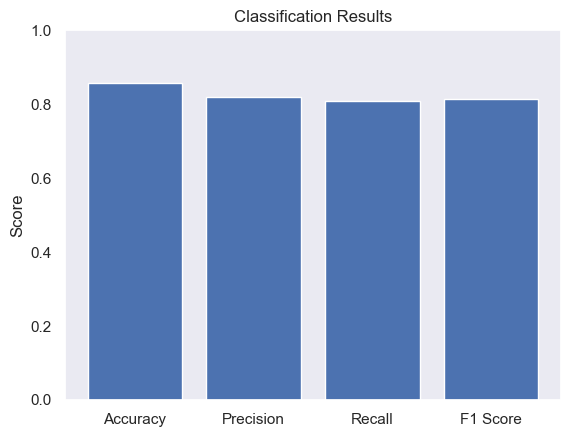

In [82]:
plot_met(val_df)

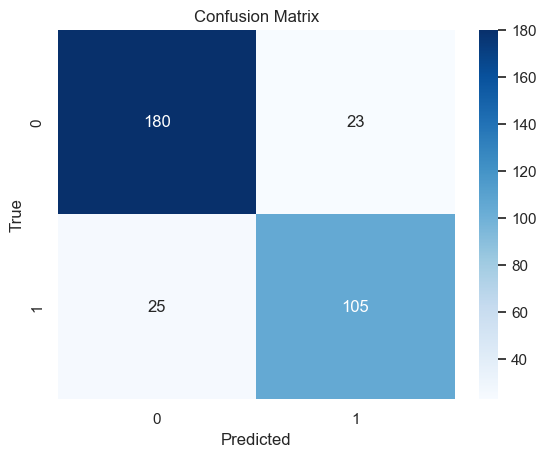

In [83]:
cmh(y_label, y_val_preds)

# For Test Split

In [84]:
x_test_feature = vgg16.predict(X_test)
n_samples = x_test_feature.shape[0]
x_test_feature_flat = np.reshape(x_test_feature, (n_samples, -1))

19/19 [==============================] - 89s 5s/step


In [85]:
y_test_preds = rf.predict(x_test_feature_flat)

In [86]:
y_test_preds.shape

(595,)

In [87]:
y_test.shape

(595,)

In [88]:
report, test_df = calculate_metrices(y_test, y_test_preds)

In [89]:
print(report)

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       317
           1       0.81      0.65      0.72       278

    accuracy                           0.76       595
   macro avg       0.77      0.76      0.76       595
weighted avg       0.77      0.76      0.76       595



In [90]:
test_df

Metric     Score
0   Accuracy  0.764706
1  Precision  0.808036
2     Recall  0.651079
3   F1 Score  0.721116

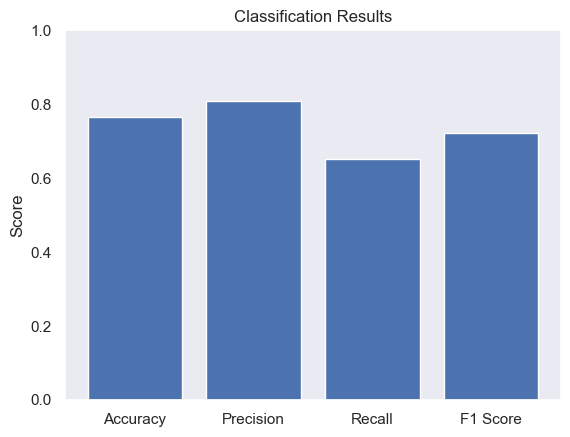

In [91]:
plot_met(test_df)

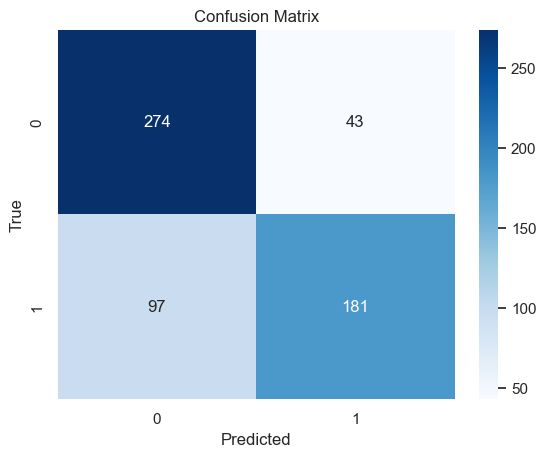

In [92]:
cmh(y_test, y_test_preds)

## Initialising a Neural Network Model - CNN

In [93]:
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Dense , Dropout , Activation
model = Sequential()
model.add(Dense(120 , input_shape =(None, 2066, 25088) ))
model.add(Activation('relu'))
model.add(Dropout(.2))

model.add(Dense(120 ))
model.add(Activation('relu'))
model.add(Dropout(.2))

model.add(Dense(120 ))
model.add(Activation('relu'))
model.add(Dropout(.2))

model.add(Dense(2))
model.add(Activation('sigmoid'))

In [94]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 2066, 120)   3010680   
                                                                 
 activation (Activation)     (None, None, 2066, 120)   0         
                                                                 
 dropout (Dropout)           (None, None, 2066, 120)   0         
                                                                 
 dense_1 (Dense)             (None, None, 2066, 120)   14520     
                                                                 
 activation_1 (Activation)   (None, None, 2066, 120)   0         
                                                                 
 dropout_1 (Dropout)         (None, None, 2066, 120)   0         
                                                                 
 dense_2 (Dense)             (None, None, 2066, 120)   1

In [95]:
model.compile(loss = 'sparse_categorical_crossentropy' , metrics =['accuracy'] ,optimizer ='adam')

In [96]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 2066, 120)   3010680   
                                                                 
 activation (Activation)     (None, None, 2066, 120)   0         
                                                                 
 dropout (Dropout)           (None, None, 2066, 120)   0         
                                                                 
 dense_1 (Dense)             (None, None, 2066, 120)   14520     
                                                                 
 activation_1 (Activation)   (None, None, 2066, 120)   0         
                                                                 
 dropout_1 (Dropout)         (None, None, 2066, 120)   0         
                                                                 
 dense_2 (Dense)             (None, None, 2066, 120)   1

In [97]:
trained = model.fit(x_train_feature_flat , y_train ,
                   batch_size = 128 , epochs = 50,
                   verbose=1 ,
                   validation_data = (x_val_feature_flat , y_label))

Epoch 1/50
17/17 [==============================] - 2s 56ms/step - loss: 0.7984 - accuracy: 0.6220 - val_loss: 0.3840 - val_accuracy: 0.8498
Epoch 2/50
17/17 [==============================] - 1s 39ms/step - loss: 0.3937 - accuracy: 0.8258 - val_loss: 0.3314 - val_accuracy: 0.8529
Epoch 3/50
17/17 [==============================] - 1s 41ms/step - loss: 0.3157 - accuracy: 0.8717 - val_loss: 0.2793 - val_accuracy: 0.8889
Epoch 4/50
17/17 [==============================] - 1s 39ms/step - loss: 0.2197 - accuracy: 0.9138 - val_loss: 0.2626 - val_accuracy: 0.8889
Epoch 5/50
17/17 [==============================] - 1s 40ms/step - loss: 0.1679 - accuracy: 0.9366 - val_loss: 0.2897 - val_accuracy: 0.8919
Epoch 6/50
17/17 [==============================] - 1s 39ms/step - loss: 0.1114 - accuracy: 0.9632 - val_loss: 0.3169 - val_accuracy: 0.8589
Epoch 7/50
17/17 [==============================] - 1s 39ms/step - loss: 0.0922 - accuracy: 0.9661 - val_loss: 0.4845 - val_accuracy: 0.8498
Epoch 8/50
17

In [98]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

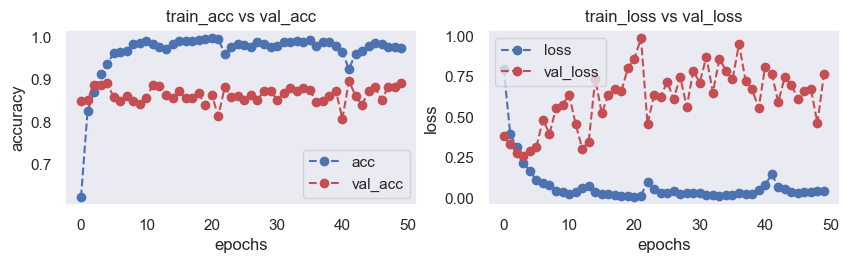

In [99]:
plot_accuracy_loss(trained)

# Testing on Validation Data

In [100]:
len(y_label)

333

In [101]:
X_train.shape

(2066, 224, 224, 3)

In [102]:
val_preds = model.predict(x_val_feature_flat)

11/11 [==============================] - 0s 6ms/step


In [103]:
val_preds.shape

(333, 2)

In [104]:
y_label.shape

(333,)

In [105]:
val_preds

array([[9.99257326e-01, 1.45756363e-04],
       [9.90134776e-01, 3.32056195e-03],
       [9.98725533e-01, 2.98940693e-04],
       [9.99997914e-01, 2.08605627e-07],
       [1.36166215e-02, 9.93937016e-01],
       [6.75476789e-01, 1.60373181e-01],
       [6.36745896e-03, 9.97139513e-01],
       [1.42848527e-03, 9.99524832e-01],
       [7.44410217e-01, 1.39295787e-01],
       [5.52153401e-02, 9.49598730e-01],
       [1.07960245e-02, 9.94852424e-01],
       [2.14920947e-04, 9.99947608e-01],
       [4.60013598e-02, 9.72796977e-01],
       [1.58625040e-02, 9.91892219e-01],
       [2.24932650e-04, 9.99944210e-01],
       [8.28307602e-05, 9.99983013e-01],
       [1.36311189e-03, 9.99550641e-01],
       [3.95334137e-05, 9.99992788e-01],
       [1.07234366e-04, 9.99977052e-01],
       [9.02184729e-06, 9.99998748e-01],
       [2.37603281e-02, 9.88206446e-01],
       [2.99998168e-02, 9.80542183e-01],
       [8.79883766e-04, 9.99718487e-01],
       [5.91493017e-06, 9.99999225e-01],
       [9.999998

In [106]:
val_result = []
for i in range(len(val_preds)):
    val_result.append(np.argmax(val_preds[i]))

In [107]:
tn, fp, fn, tp = confusion_matrix(y_label,val_result).ravel()

In [108]:
(tn, fp, fn, tp)

(189, 14, 22, 108)

In [109]:
val_report, val_df = calculate_metrices(y_label, val_result)

In [110]:
print(val_report)

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       203
           1       0.89      0.83      0.86       130

    accuracy                           0.89       333
   macro avg       0.89      0.88      0.89       333
weighted avg       0.89      0.89      0.89       333



In [111]:
val_df

Metric     Score
0   Accuracy  0.891892
1  Precision  0.885246
2     Recall  0.830769
3   F1 Score  0.857143

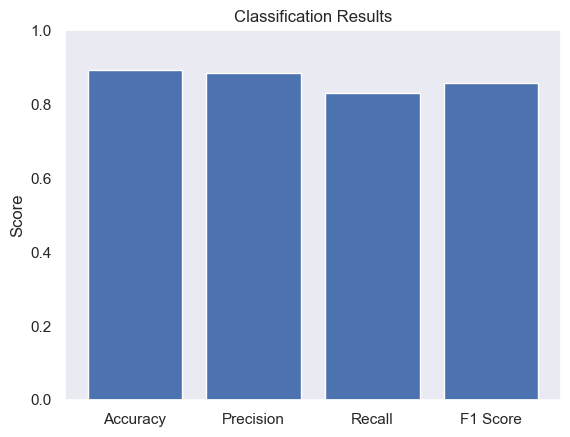

In [112]:
plot_met(val_df)

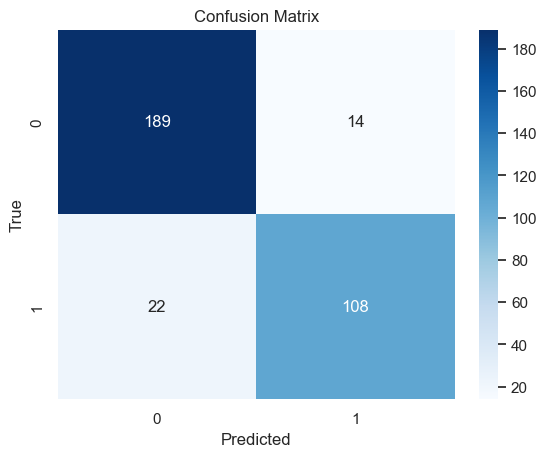

In [113]:
cmh(y_label, val_result)

# Testing on Test Data

In [114]:
test_preds = model.predict(x_test_feature_flat)

19/19 [==============================] - 0s 6ms/step


In [115]:
y_test.shape

(595,)

In [116]:
test_preds.shape

(595, 2)

In [117]:
test_result = []
for i in range(len(test_preds)):
    test_result.append(np.argmax(test_preds[i]))

In [118]:
tn, fp, fn, tp = confusion_matrix(y_test,test_result).ravel()

In [119]:
tn, fp, fn, tp 

(290, 27, 79, 199)

In [120]:
test_report, test_df = calculate_metrices(y_test, test_result)

In [121]:
print(test_report)

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       317
           1       0.88      0.72      0.79       278

    accuracy                           0.82       595
   macro avg       0.83      0.82      0.82       595
weighted avg       0.83      0.82      0.82       595



In [122]:
test_df

Metric     Score
0   Accuracy  0.821849
1  Precision  0.880531
2     Recall  0.715827
3   F1 Score  0.789683

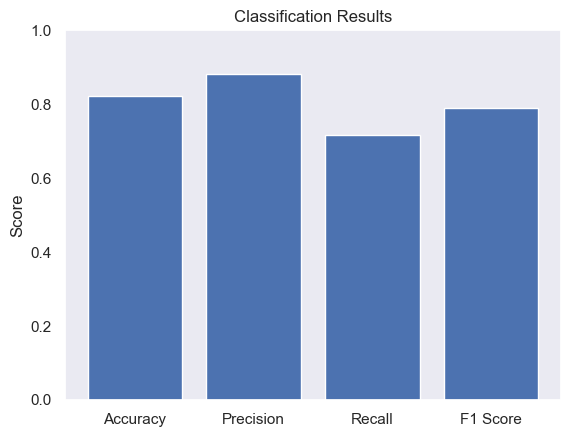

In [123]:
plot_met(test_df)

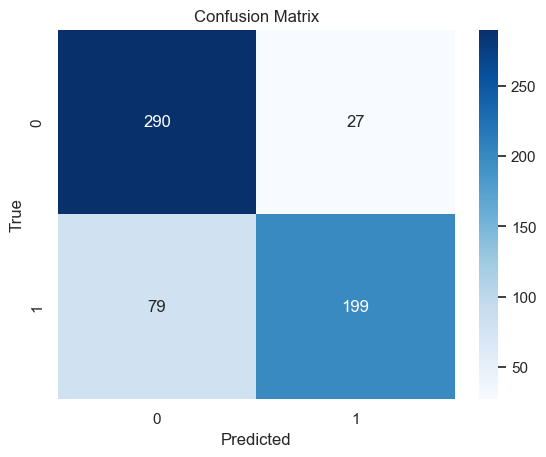

In [124]:
cmh(y_test, test_result)

In [130]:
model.save('FINAL.h5')

In [232]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Model 3

In [131]:
train_info.loc[train_info['name']=='image (101)']

xmin  ymin  xmax  ymax         name   label
4    13   110   213   375  image (101)  person
5   149   127   355   375  image (101)  person
6   292    61   500   375  image (101)  person

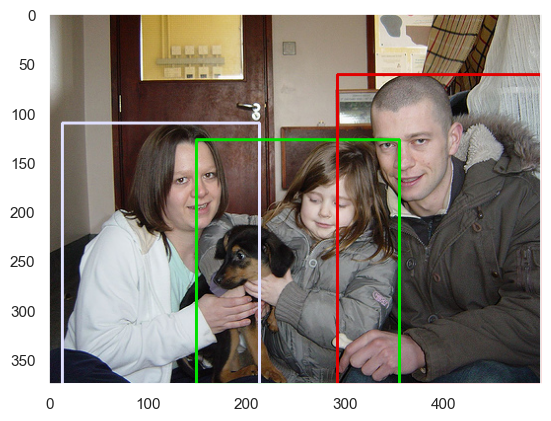

In [132]:
img=cv2.imread(train_path+'/image (101).jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

cv2.rectangle(img,(13,110),(213,375),(225,225,255),2)
cv2.rectangle(img,(149,127),(355,375),(0,225,0),2)
cv2.rectangle(img,(292,61),(500,375),(225,0,0),2)

plt.imshow(img)

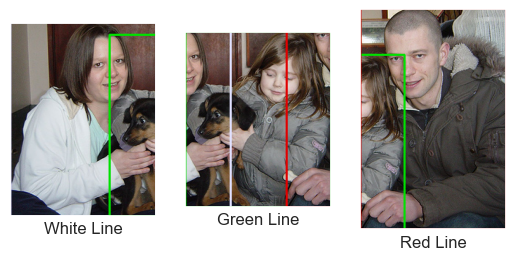

In [133]:
#  y-min, y-max , x-min , x-max
fig=plt.figure()

plt.subplot(1,3,1)
plt.imshow(img[110:375,13:213])
plt.xticks([])
plt.yticks([])
plt.xlabel('White Line')

plt.subplot(1,3,2)
plt.imshow(img[127:375,149:355])
plt.xticks([])
plt.yticks([])
plt.xlabel('Green Line')

plt.subplot(1,3,3)
plt.imshow(img[61:375,292:500])
plt.xticks([])
plt.yticks([])
plt.xlabel('Red Line')

plt.show()

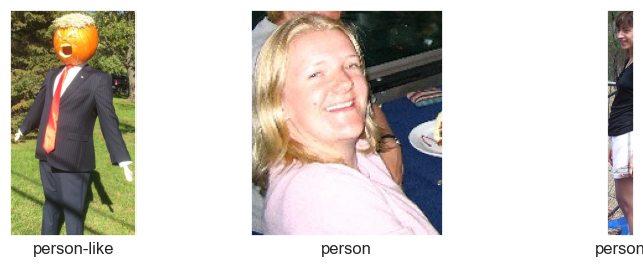

In [134]:
fig=plt.figure(figsize=(10,10))

for i in range (1,4):
    random=np.random.randint(0,len(trainImage))
    plt.subplot(3,3,i)
    plt.imshow(trainImage[random])
    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

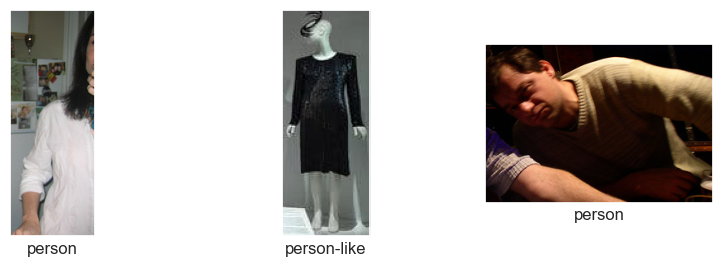

In [135]:
fig=plt.figure(figsize=(10,10))

for i in range (1,4):
    random=np.random.randint(0,len(trainImage))
    plt.subplot(3,3,i)
    plt.imshow(trainImage[random])
    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

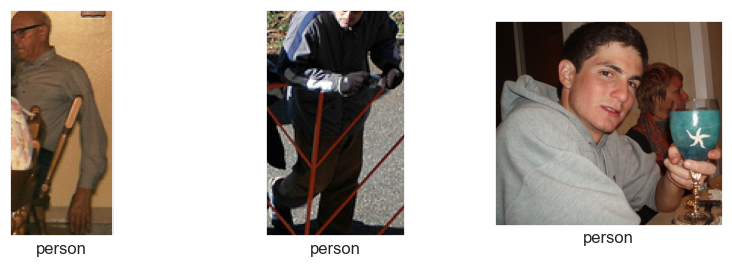

In [136]:
fig=plt.figure(figsize=(10,10))

for i in range (1,4):
    random=np.random.randint(0,len(valImage))
    plt.subplot(3,3,i)
    plt.imshow(trainImage[random])
    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

In [137]:
from skimage import color
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
data_gray = [ color.rgb2gray(i) for i in trainImage]

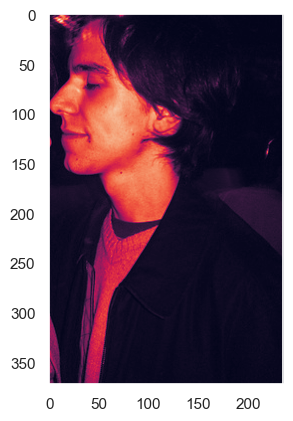

In [138]:
plt.imshow(data_gray[51])

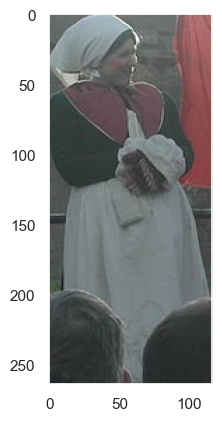

In [139]:
plt.imshow(trainImage[20])

In [140]:
trainLabel[20]

'person'

In [141]:
ppc = 16
hog_images = []
hog_features = []
for image in trainImage:
    resized_img = resize(image, (128,64))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

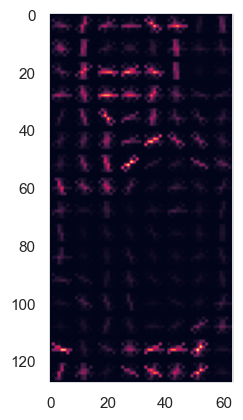

In [142]:
plt.imshow(hog_images[53])

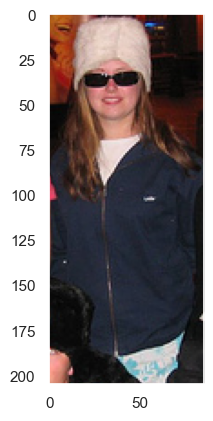

In [143]:
plt.imshow(trainImage[53])

In [144]:
labels =  np.array(trainLabel).reshape(len(trainLabel),1) 

In [145]:
hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features,labels))

In [146]:
data_frame[20]

array(['0.03325345249882348', '0.23313969780291072',
       '0.31053199734428377', ..., '0.07051015970974712',
       '0.1019977762169178', 'person'], dtype='<U32')

In [147]:
np.random.shuffle(data_frame)

In [148]:
data_frame[0]

array(['0.262312351698484', '0.262312351698484', '0.1864629289956521',
       ..., '0.1712583030341586', '0.3519459272206954', 'person'],
      dtype='<U32')

In [149]:
x_train = data_frame[:len(hog_features),:-1]

In [150]:
x_train[0]

array(['0.262312351698484', '0.262312351698484', '0.1864629289956521',
       ..., '0.0', '0.1712583030341586', '0.3519459272206954'],
      dtype='<U32')

In [151]:
y_train = data_frame[:len(hog_features),-1:].ravel() #revel -> array flatten

In [152]:
y_train[0]

'person'

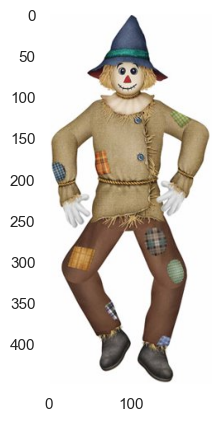

In [153]:
plt.imshow(testImage[200])

In [154]:
ppc = 16
hog_images = []
hog_features = []
for image in testImage:
    resized_img = resize(image, (128,64))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

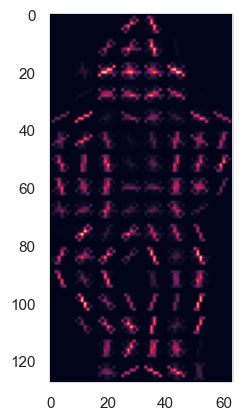

In [155]:
plt.imshow(hog_images[200])

In [156]:
testLabel[200]

'person-like'

In [157]:
labels =  np.array(testLabel).reshape(len(testLabel),1) 

In [158]:
hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features,labels)) #hstack to make a single array .

In [159]:
data_frame[200]

array(['0.4263623127559023', '0.0', '5.5747959119597e-14', ..., '0.0',
       '0.0', 'person-like'], dtype='<U32')

In [160]:
np.random.shuffle(data_frame)

In [161]:
data_frame[200]

array(['0.07269700676178158', '0.075436573137202', '0.10116314093605214',
       ..., '0.06840157247208604', '0.16097956610894107', 'person'],
      dtype='<U32')

In [162]:
x_test = data_frame[:len(hog_features),:-1]

In [163]:
x_test[200]

array(['0.07269700676178158', '0.075436573137202', '0.10116314093605214',
       ..., '0.17501615992573546', '0.06840157247208604',
       '0.16097956610894107'], dtype='<U32')

In [164]:
y_test = data_frame[:len(hog_features),-1:].ravel() #revel -> array flatten

In [165]:
y_test[200]

'person'

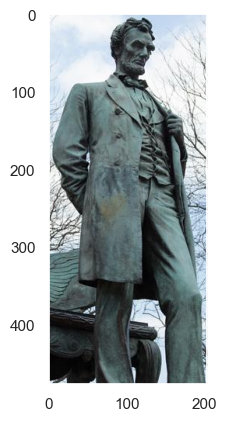

In [166]:
plt.imshow(valImage[37])

In [167]:
from skimage.feature import hog
ppc = 16
hog_images = []
hog_features = []
for image in valImage:
    resized_img = resize(image, (128,64))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

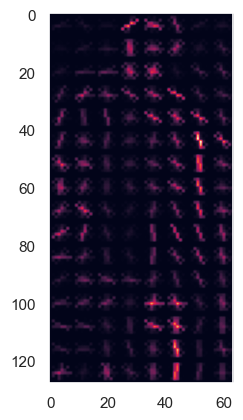

In [168]:
plt.imshow(hog_images[37])

In [169]:
valLabel[37]

'person-like'

In [170]:
labels =  np.array(valLabel).reshape(len(valLabel),1) 

In [171]:
hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features,labels)) #hstack to make a single array . 

In [172]:
data_frame[37]

array(['0.15852594189294084', '0.024180799349487112',
       '0.18452992556646375', ..., '0.08465030480095855',
       '0.2982295433258639', 'person-like'], dtype='<U32')

In [173]:
np.random.shuffle(data_frame)

In [174]:
data_frame[37]

array(['0.2375226565991267', '0.05802251160915456', '0.11883004364651907',
       ..., '0.08943074287774778', '0.09005007204957265', 'person-like'],
      dtype='<U32')

In [175]:
x_val = data_frame[:len(hog_features),:-1]

In [176]:
x_val[37]

array(['0.2375226565991267', '0.05802251160915456', '0.11883004364651907',
       ..., '0.06507564606608857', '0.08943074287774778',
       '0.09005007204957265'], dtype='<U32')

In [177]:
y_val = data_frame[:len(hog_features),-1:].ravel() #revel -> array flatten .

In [178]:
y_val[37]

'person-like'

In [179]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [180]:
svm = SVC()

In [181]:
svm.fit(x_train, y_train)

SVC()

In [182]:
print('train acc ' , svm.score(x_train,y_train))

train acc  0.9598257502420136


In [183]:
val_preds = svm.predict(x_val)
val_acc = accuracy_score(y_val, val_preds)

In [184]:
val_acc

0.7447447447447447

In [185]:
val_precision_p = precision_score(y_val, val_preds, pos_label="person")
val_recall_p = recall_score(y_val, val_preds,pos_label="person")
val_f1_p = f1_score(y_val, val_preds, pos_label="person")

In [186]:
val_precision_p, val_recall_p, val_f1_p

(0.795, 0.7832512315270936, 0.7890818858560794)

In [187]:
val_precision_pl = precision_score(y_val, val_preds, pos_label="person-like")
val_recall_pl = recall_score(y_val, val_preds,pos_label="person-like")
val_f1_pl = f1_score(y_val, val_preds, pos_label="person-like")

In [188]:
val_precision_pl, val_recall_pl, val_f1_pl

(0.6691729323308271, 0.6846153846153846, 0.6768060836501901)

In [189]:
from sklearn.metrics import confusion_matrix

In [190]:
cm = confusion_matrix(y_val, val_preds)

In [191]:
cm

array([[159,  44],
       [ 41,  89]], dtype=int64)

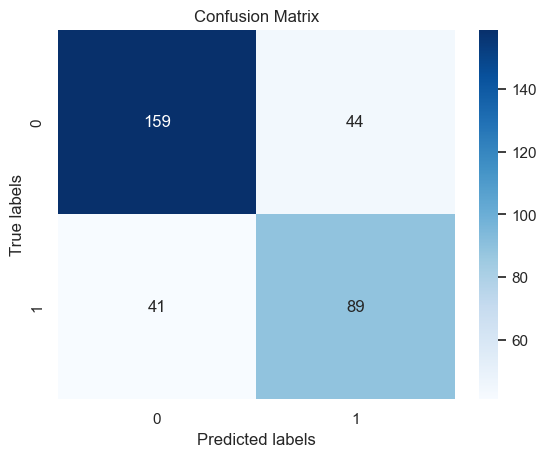

In [192]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# add labels and title to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show();

In [193]:
test_preds = svm.predict(x_test)

In [194]:
labels = np.unique(y_val)

In [195]:
labels

array(['person', 'person-like'], dtype='<U32')

In [196]:
from sklearn.metrics import classification_report
val_report = classification_report(y_val, val_preds, output_dict=True)

In [198]:
accuracy = val_report['accuracy']
precision = [val_report[label]['precision'] for label in np.unique(labels)]
recall = [val_report[label]['recall'] for label in np.unique(labels)]
f1 = [val_report[label]['f1-score'] for label in np.unique(labels)]

In [199]:
precision

[0.795, 0.6691729323308271]

In [200]:
x = np.arange(len(labels))
width = 0.2

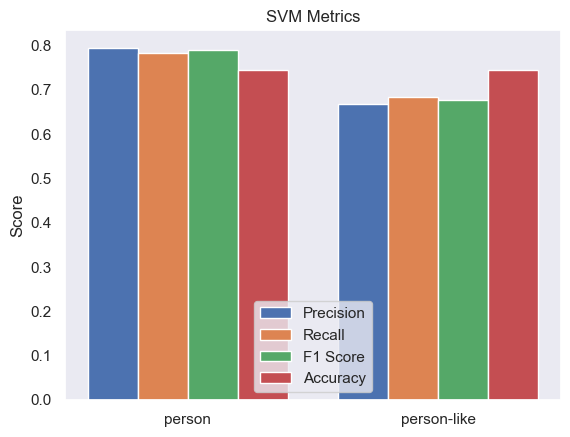

In [201]:
fig, ax = plt.subplots()
ax.bar(x - 1.5*width, precision, width, label='Precision')
ax.bar(x - 0.5*width, recall, width, label='Recall')
ax.bar(x + 0.5*width, f1, width, label='F1 Score')
ax.bar(x + 1.5*width, [accuracy]*len(labels), width, label='Accuracy')

ax.set_ylabel('Score')
ax.set_title('SVM Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [202]:
import pandas as pd

def report_to_dataframe(report):
    rows = []
    for class_name, metrics in report.items():
        if class_name == "accuracy":
            continue
        row = [class_name, metrics["precision"], metrics["recall"], metrics["f1-score"], metrics["support"]]
        rows.append(row)
    df = pd.DataFrame(rows, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
    df.loc[len(df)] = ["Accuracy", report["accuracy"], "", "", ""]
    return df

In [203]:
val_df = report_to_dataframe(val_report)

In [204]:
val_df

Class  Precision    Recall  F1-score Support
0        person   0.795000  0.783251  0.789082     203
1   person-like   0.669173  0.684615  0.676806     130
2     macro avg   0.732086  0.733933  0.732944     333
3  weighted avg   0.745878  0.744745   0.74525     333
4      Accuracy   0.744745

In [205]:
report = classification_report(y_test, test_preds, output_dict=True)

In [206]:
accuracy = report['accuracy']
precision = [report[label]['precision'] for label in np.unique(labels)]
recall = [report[label]['recall'] for label in np.unique(labels)]
f1 = [report[label]['f1-score'] for label in np.unique(labels)]

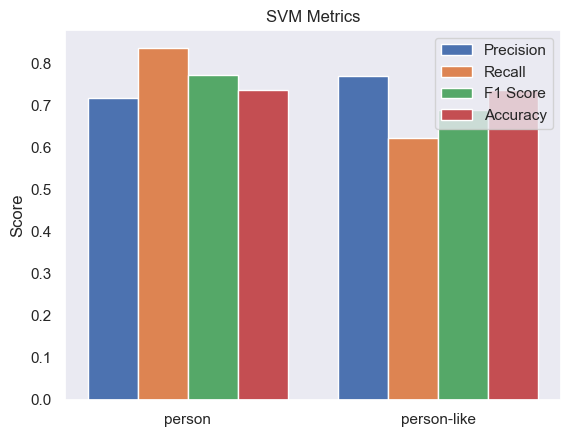

In [207]:
fig, ax = plt.subplots()
ax.bar(x - 1.5*width, precision, width, label='Precision')
ax.bar(x - 0.5*width, recall, width, label='Recall')
ax.bar(x + 0.5*width, f1, width, label='F1 Score')
ax.bar(x + 1.5*width, [accuracy]*len(labels), width, label='Accuracy')

ax.set_ylabel('Score')
ax.set_title('SVM Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [208]:
cm = confusion_matrix(y_test, test_preds)

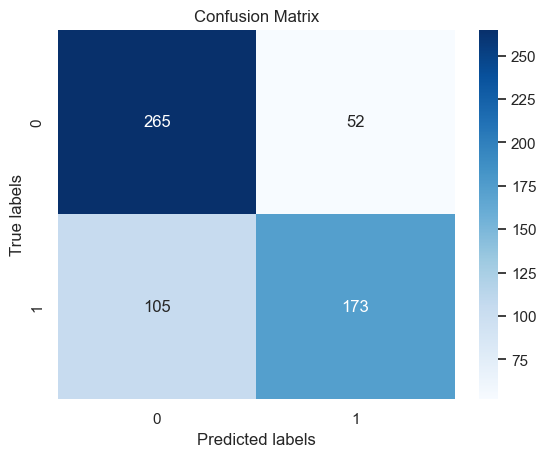

In [209]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# add labels and title to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show();

In [210]:
test_df = report_to_dataframe(report)

In [211]:
test_df

Class  Precision    Recall  F1-score Support
0        person   0.716216  0.835962   0.77147     317
1   person-like   0.768889  0.622302  0.687873     278
2     macro avg   0.742553  0.729132  0.729671     595
3  weighted avg   0.740826  0.736134  0.732411     595
4      Accuracy   0.736134

In [212]:
print(report)

{'person': {'precision': 0.7162162162162162, 'recall': 0.8359621451104101, 'f1-score': 0.7714701601164483, 'support': 317}, 'person-like': {'precision': 0.7688888888888888, 'recall': 0.6223021582733813, 'f1-score': 0.6878727634194831, 'support': 278}, 'accuracy': 0.7361344537815127, 'macro avg': {'precision': 0.7425525525525525, 'recall': 0.7291321516918957, 'f1-score': 0.7296714617679657, 'support': 595}, 'weighted avg': {'precision': 0.7408263052968935, 'recall': 0.7361344537815127, 'f1-score': 0.732411208382404, 'support': 595}}


In [213]:
avg_precision = precision_score(y_test, test_preds, average='macro')

In [214]:
avg_precision

0.7425525525525525

In [215]:
avg_recall = recall_score(y_test, test_preds, average='macro')

In [216]:
avg_recall

0.7291321516918957

In [217]:
avg_f1 = f1_score(y_test, test_preds, average='macro')

In [218]:
avg_f1

0.7296714617679657